# **Homework \#7 numerical exercise:** training DNNs for function regression

In this exercise you will train a neural network, defined by the Python and TensorFlow code below, on function samples.

For fast computation, ensure that the hardware accelerator is set to "GPU" under Edit -> Notebook Settings above.

First, we import necessary packages.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import copy


The functions we will approximate are $$f_1(x) = \log(\sin(10x)+2)+\sin(x),$$ and
$$ f_2(x) = \begin{cases} x^2 & x < -\frac{1}{2} \\
x+5 & -\frac12 \le x < 0 \\
-x &  0 \le x < \frac12 \\
\log(x) + 2 & \frac12 \le x.
\end{cases}$$ The code below generates the training and testing data for this function with linearly-spaced sample points and plots on the testing data.

/var/folders/yr/jxh1gyj14ydcw5p3l432q1r00000gn/T/ipykernel_34220/1794809490.py:14: RuntimeWarning: invalid value encountered in log
  np.where(np.less_equal(x,  0.5), -x, np.log(x) + 2)))


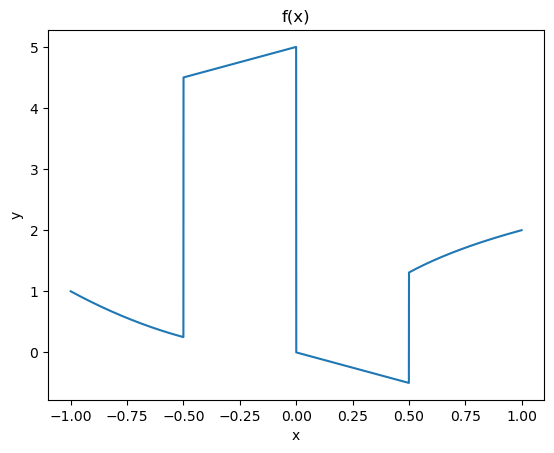

In [2]:
################################################
### PART 1: Generating the data and plotting ###
################################################

example = 2

if example == 1:
    f = lambda x: np.log(np.sin(10.0*x) + 2.0) + np.sin(x)
    plot_ylim_l = -3
    plot_ylim_u = 3
elif example == 2:
    f = lambda x: np.where(np.less_equal(x, -0.5), np.square(x),
                  np.where(np.less_equal(x,  0.0), x + 5,
                  np.where(np.less_equal(x,  0.5), -x, np.log(x) + 2)))
    plot_ylim_l = -2
    plot_ylim_u = 6

m_train = 500
x_train_data = np.linspace(-1.0, 1.0, num=m_train).reshape(-1, 1).astype(np.float32)
y_train_data = f(x_train_data).reshape(-1, 1).astype(np.float32)

m_test = 10000
x_test_data = np.linspace(-1.0, 1.0, num=m_test).reshape(-1, 1).astype(np.float32)
y_test_data = f(x_test_data).reshape(-1, 1).astype(np.float32)

plt.title("f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x_test_data, y_test_data)
plt.show()



In [3]:
######################################
### PART 2: Setup and training DNN ###
######################################

test_interval = 1000
activation = 'tanh'
layers = 10
nodes_per_layer = 100
total_epochs = 50000
error_tol = 5e-7
init_rate = 0.001

# Define the neural network model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module("input_layer", nn.Linear(1, nodes_per_layer))
        for layer in range(layers):
            self.layers.add_module(f"dense_{layer}", nn.Linear(nodes_per_layer, nodes_per_layer))
            self.layers.add_module(f"activation_{layer}", nn.Tanh())
        self.layers.add_module("output_layer", nn.Linear(nodes_per_layer, 1))

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss function, and optimizer
model = DNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=init_rate)

exp_decay_sched = True

if exp_decay_sched:
    # Exponentially decaying learning rate scheduler
    decay_rate = (error_tol/init_rate)**(1/total_epochs)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=decay_rate,last_epoch=-1)
else:
    # Plateau learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Prepare data loaders
train_dataset = TensorDataset(torch.from_numpy(x_train_data), torch.from_numpy(y_train_data))
train_loader = DataLoader(train_dataset, batch_size=m_train, shuffle=True)

# Early stopping parameters
best_loss_epoch = 0
best_loss = float('inf')
patience = float('inf')  # Number of epochs to wait for improvement
patience_counter = 0
best_model = copy.deepcopy(model)

# Training loop
predictions = []
prediction_steps = []
test_losses = []
losses = []
steps = []
for epoch in range(total_epochs):
    model.train()
    steps.append(epoch)
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    current_loss = loss.item()
    losses.append(current_loss)

    if exp_decay_sched:
        scheduler.step()
    else:
        scheduler.step(current_loss)  # Update learning rate based on training loss

    current_lr = optimizer.state_dict()['param_groups'][0]['lr']

    # Early stopping check
    if current_loss < best_loss:
        #print('saving model')
        best_loss = current_loss
        best_loss_epoch = epoch
        best_model = copy.deepcopy(model)
        patience_counter = 0  # Reset counter if we have an improvement
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

    # Validation
    if epoch % test_interval == 0:
        with torch.no_grad():
            model.eval()
            y_pred = model(torch.from_numpy(x_test_data))
            test_loss = criterion(y_pred, torch.from_numpy(y_test_data))
            print(f'Epoch {epoch:5d}: Loss = {loss.item():5.8e}, Validation Loss = {test_loss.item():5.8e}, LR = {current_lr:5.8e}')

            predictions.append(y_pred.numpy())
            test_losses.append(test_loss.item())
            prediction_steps.append(epoch)


if best_loss < current_loss:
    print('restoring model from memory, epoch =', best_loss_epoch)
    model = copy.deepcopy(best_model)

# Final test predictions
y_final_pred = model(torch.from_numpy(x_test_data))
#final_test_err = torch.sqrt((torch.from_numpy(y_test_data - y_final_pred.detach().numpy()) ** 2).mean())
final_test_err = criterion(y_final_pred, torch.from_numpy(y_test_data))
print('Final Test Error:', final_test_err.item())



Epoch     0: Loss = 6.71936989e+00, Validation Loss = 6.43702984e+00, LR = 9.99847994e-04
Epoch  1000: Loss = 4.38410416e-03, Validation Loss = 1.12421019e-02, LR = 8.58842207e-04
Epoch  2000: Loss = 6.88148290e-03, Validation Loss = 1.64317191e-02, LR = 7.37722076e-04
Epoch  3000: Loss = 1.78183794e-01, Validation Loss = 1.77518964e-01, LR = 6.33683180e-04
Epoch  4000: Loss = 5.74997917e-04, Validation Loss = 1.98062845e-02, LR = 5.44316601e-04
Epoch  5000: Loss = 4.47763741e-01, Validation Loss = 4.23642635e-01, LR = 4.67553142e-04
Epoch  6000: Loss = 9.18233927e-05, Validation Loss = 1.38975773e-02, LR = 4.01615421e-04
Epoch  7000: Loss = 2.99066796e-05, Validation Loss = 1.45384017e-02, LR = 3.44976713e-04
Epoch  8000: Loss = 1.29213058e-05, Validation Loss = 1.60149951e-02, LR = 2.96325605e-04
Epoch  9000: Loss = 6.03609369e-04, Validation Loss = 7.25507131e-03, LR = 2.54535628e-04
Epoch 10000: Loss = 1.47933970e-04, Validation Loss = 6.14922727e-03, LR = 2.18639175e-04
Epoch 1100

The block of code below initializes and trains a fully-connected feed-forward DNN on the training data above, and records the predictions on the testing data every "test_interval" epochs of training. Change this parameter to plot more or less often. Note that setting test_interval to 1 or 10 can result in a large computation time due to having to test the DNN often on a large testing set.

The code below generates a movie from the predictions on the test data of the neural network trained in the block above.

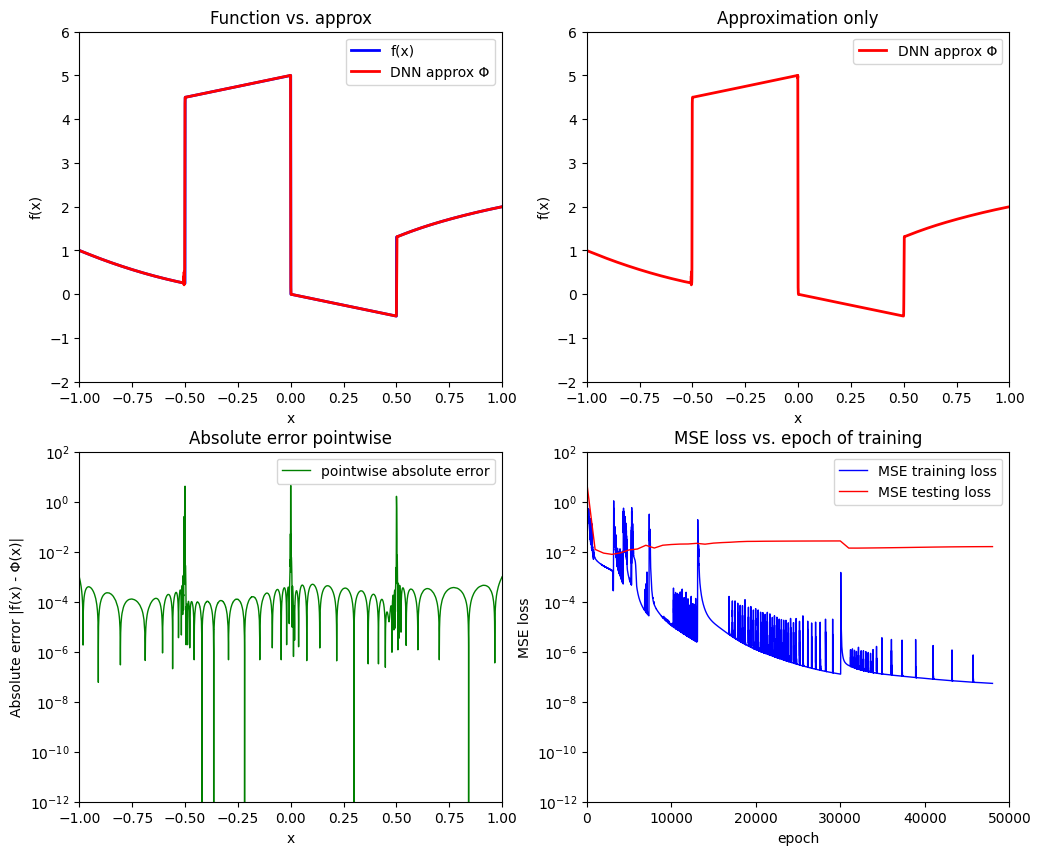

In [ ]:
#####################################
### PART 3: Generating animations ###
#####################################

def drawframe(n, x_test_data, y_test_data, model_predictions, model_prediction_steps, model_test_losses, model_steps, model_losses):
    line1.set_data(x_test_data, y_test_data)
    line2.set_data(x_test_data, model_predictions[n])
    line3.set_data(x_test_data, model_predictions[n])
    line4.set_data(x_test_data, abs(y_test_data - model_predictions[n]))
    line5.set_data(model_steps[0:(n-1)*test_interval], np.abs(model_losses[0:(n-1)*test_interval]))
    line6.set_data(model_prediction_steps[0:n], np.abs(model_test_losses[0:n]))
    return (line1, line2, line3, line4, line5)

fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

ax1.set_xlim((-1, 1))
ax1.set_ylim((plot_ylim_l, plot_ylim_u))
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')

ax2.set_xlim((-1, 1))
ax2.set_ylim((plot_ylim_l, plot_ylim_u))
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')

ax3.set_xlim((-1, 1))
ax3.set_ylim((1e-12, 1e2))
ax3.set_xlabel('x')
ax3.set_ylabel('Absolute error |f(x) - Φ(x)|')

ax4.set_xlim((0, total_epochs))
ax4.set_xlabel('epoch')
ax4.set_ylim((1e-12, 1e2))
ax4.set_ylabel('MSE loss')

txt_title1 = ax1.set_title('Function vs. approx')
txt_title2 = ax2.set_title('Approximation only')
txt_title3 = ax3.set_title('Absolute error pointwise')
txt_title4 = ax4.set_title('MSE loss vs. epoch of training')
line1, = ax1.plot([], [], 'b', lw=2)
line2, = ax1.plot([], [], 'r', lw=2)
line3, = ax2.plot([], [], 'r', lw=2)
line4, = ax3.semilogy([], [], 'g', lw=1)
line5, = ax4.semilogy([], [], 'b', lw=1)
line6, = ax4.semilogy([], [], 'r', lw=1)
ax1.legend(['f(x)', 'DNN approx Φ']);
ax2.legend(['DNN approx Φ']);
ax3.legend(['pointwise absolute error']);
ax4.legend(['MSE training loss','MSE testing loss']);


anim = animation.FuncAnimation(fig, drawframe, frames=len(predictions),
                               fargs=(x_test_data, y_test_data, predictions,
                                      prediction_steps, test_losses, steps,
                                      losses), interval=100, blit=True)

HTML(anim.to_html5_video())


In [ ]:
print(losses)

[6.733080863952637, 6.453733444213867, 6.165372848510742, 5.823671817779541, 5.384995937347412, 4.825608730316162, 4.2036285400390625, 3.7195260524749756, 3.6398329734802246, 3.9223501682281494, 4.11793851852417, 4.0897626876831055, 3.93144154548645, 3.7553303241729736, 3.640871047973633, 3.618236780166626, 3.6669347286224365, 3.735741138458252, 3.7793993949890137, 3.7813215255737305, 3.748839855194092, 3.700047254562378, 3.6538279056549072, 3.623833179473877, 3.6153929233551025, 3.625199317932129, 3.6438539028167725, 3.6604840755462646, 3.66740083694458, 3.6625466346740723, 3.649015426635742, 3.632650852203369, 3.6192338466644287, 3.6123836040496826, 3.6126978397369385, 3.618109703063965, 3.6250550746917725, 3.629878520965576, 3.630129337310791, 3.6255390644073486, 3.618014335632324, 3.610380172729492, 3.6048147678375244, 3.6019389629364014, 3.6006994247436523, 3.5987932682037354, 3.5933632850646973, 3.582054853439331, 3.5659308433532715, 3.5532610416412354, 3.5369303226470947, 3.5108